# Adam Volin - IS362 Final Project

This project will use data from NYC Open Data (https://opendata.cityofnewyork.us). The URLs for the source of each dataset is listed in their respective sections of this notebook. Field descriptions are available at the respective URLs.

The purpose of this project is to analyze the NYC tree population utilizing several datasets from NYC Open Data, transform and tidy the datasets as necessary and then answer several questions. I am interested in this data because I have requested several trees to be planted through the MillionTrees NYC initiative (https://www.milliontreesnyc.org). I am curious to learn about the different tree species located throughout the boroughs, especially the least common species as I do not encounter them regularly, as well as the overall health of the tree population. By the end of this project, I'm aiming to discover which borough has the highest tree density.

Let's start with imports:

In [1]:
# Imports
import requests
import pandas as pd
import geopandas as gp
from pandas.io.json import json_normalize
from dateutil import parser
import seaborn as sb
import matplotlib.pyplot as plt
%matplotlib inline
from zipfile import ZipFile

# Setup pandas to show all columns and limit row previews to 10 rows
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 12)

## Dataset 1: 2015 Street Tree Census

The 2015 Street Tree Census dataset is available at https://data.cityofnewyork.us/Environment/2015-Street-Tree-Census-Tree-Data/uvpi-gqnh. Tree data in the dataset includes tree species, diameter and perception of health. Accompanying blockface data is available indicating status of data collection and data release citywide.

The source dataset has ~684,000 rows and 45 columns. We will download the source dataset in it's entirety. API documentation is available at https://dev.socrata.com/foundry/data.cityofnewyork.us/uvpi-gqnh. The dataset CSV export URL is https://data.cityofnewyork.us/api/views/uvpi-gqnh/rows.csv?accessType=DOWNLOAD.

Let's unzip and load the data into pandas:

In [2]:
# Unzip the previously downloaded and compressed CSV file
zf = ZipFile('data/2015_street_tree_census.zip', 'r')
zf.extractall('data')
zf.close()

# Load the data into a dataframe
trees = pd.read_csv('data/2015_street_tree_census.csv')
# Preview the data

trees.head(5)

,tree_id,block_id,created_at,tree_dbh,stump_diam,curb_loc,status,health,spc_latin,spc_common,steward,guards,sidewalk,user_type,problems,root_stone,root_grate,root_other,trunk_wire,trnk_light,trnk_other,brch_light,brch_shoe,brch_other,address,postcode,zip_city,community board,borocode,borough,cncldist,st_assem,st_senate,nta,nta_name,boro_ct,state,latitude,longitude,x_sp,y_sp,council district,census tract,bin,bbl
0,180683,348711,08/27/2015,3,0,OnCurb,Alive,Fair,Acer rubrum,red maple,None,None,NoDamage,TreesCount Staff,None,No,No,No,No,No,No,No,No,No,108-005 70 AVENUE,11375,Forest Hills,406,4,Queens,29,28,16,QN17,Forest Hills,4073900,New York,40.723092,-73.844215,1027431.148,202756.7687,29.0,739.0,4052307.0,4.022210e+09
1,200540,315986,09/03/2015,21,0,OnCurb,Alive,Fair,Quercus palustris,pin oak,None,None,Damage,TreesCount Staff,Stones,Yes,No,No,No,No,No,No,No,No,147-074 7 AVENUE,11357,Whitestone,407,4,Queens,19,27,11,QN49,Whitestone,4097300,New York,40.794111,-73.818679,1034455.701,228644.8374,19.0,973.0,4101931.0,4.044750e+09
2,204026,218365,09/05/2015,3,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,1or2,None,Damage,Volunteer,None,No,No,No,No,No,No,No,No,No,390 MORGAN AVENUE,11211,Brooklyn,301,3,Brooklyn,34,50,18,BK90,East Williamsburg,3044900,New York,40.717581,-73.936608,1001822.831,200716.8913,34.0,449.0,3338310.0,3.028870e+09
3,204337,217969,09/05/2015,10,0,OnCurb,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,None,None,Damage,Volunteer,Stones,Yes,No,No,No,No,No,No,No,No,1027 GRAND STREET,11211,Brooklyn,301,3,Brooklyn,34,53,18,BK90,East Williamsburg,3044900,New York,40.713537,-73.934456,1002420.358,199244.2531,34.0,449.0,3338342.0,3.029250e+09
4,189565,223043,08/30/2015,21,0,OnCurb,Alive,Good,Tilia americana,American linden,None,None,Damage,Volunteer,Stones,Yes,No,No,No,No,No,No,No,No,603 6 STREET,11215,Brooklyn,306,3,Brooklyn,39,44,21,BK37,Park Slope-Gowanus,3016500,New York,40.666778,-73.975979,990913.775,182202.4260,39.0,165.0,3025654.0,3.010850e+09


#### Let's confirm that the dataframe matches the expected dataset record and column count:

In [3]:
# Get the dataframe shape
trees.shape

(683788, 45)

Looking good. As we can see above, there are spaces in some of the column names which are difficult to work with using pandas functions. Let's remove the spaces and covert the column names to lowercase.
There are also many columns in here that are not applicable for the analysis to be done. Let's drop them as well:

In [4]:
# Get the current column names use a lambda to replace spaces with underscores and change them to lowercase
cols = trees.columns
cols = cols.map(lambda x: x.replace(' ', '_').lower())
trees.columns = cols

# Drop the unnecessary columns
trees = trees.drop([  'block_id',
                      'tree_dbh',
                      'stump_diam',
                      'curb_loc',
                      'steward',
                      'guards',
                      'sidewalk',
                      'user_type',
                      'problems',
                      'root_stone',
                      'root_grate',
                      'root_other',
                      'trunk_wire',
                      'trnk_light',
                      'trnk_other',
                      'brch_light',
                      'brch_shoe',
                      'brch_other',
                      'address',
                      'zip_city',
                      'community_board',
                      'borocode',
                      'cncldist',
                      'st_assem',
                      'st_senate',
                      'nta',
                      'nta_name',
                      'boro_ct',
                      'state',
                      'x_sp',
                      'y_sp',
                      'council_district',
                      'zip_city',
                      'community_board',
                      'census_tract',
                      'bin',
                      'bbl'
                     ], axis=1)

# Preview the data
trees.head(5)

,tree_id,created_at,status,health,spc_latin,spc_common,postcode,borough,latitude,longitude
0,180683,08/27/2015,Alive,Fair,Acer rubrum,red maple,11375,Queens,40.723092,-73.844215
1,200540,09/03/2015,Alive,Fair,Quercus palustris,pin oak,11357,Queens,40.794111,-73.818679
2,204026,09/05/2015,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,11211,Brooklyn,40.717581,-73.936608
3,204337,09/05/2015,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,11211,Brooklyn,40.713537,-73.934456
4,189565,08/30/2015,Alive,Good,Tilia americana,American linden,11215,Brooklyn,40.666778,-73.975979


Now that we've transformed the dataset, let's move onto the next dataset.

## Dataset 2: Forestry Service Requests

The Forestry Service Requests dataset is available at https://data.cityofnewyork.us/Environment/Forestry-Service-Requests/mu46-p9is.

The source dataset has 429,000 rows and 47 columns. We will download the source dataset in it's entirety. API documentation is available at https://dev.socrata.com/foundry/data.cityofnewyork.us/mu46-p9is. The dataset CSV export URL is https://data.cityofnewyork.us/api/views/mu46-p9is/rows.csv?accessType=DOWNLOAD.


Let's unzip and load the data into pandas:

In [5]:
# Unzip the previously downloaded and compressed CSV file
zf = ZipFile('data/forestry_service_requests.zip', 'r')
zf.extractall('data')
zf.close()

# Load the data into a dataframe
service_requests = pd.read_csv('data/forestry_service_requests.csv')
# Preview the data
service_requests.head(5)

,objectid,complaintnumber,srcategory,srtype,srpriority,srsource,srstatus,srresolution,boroughcode,communityboard,buildingnumber,streetname,crossstreet1,crossstreet2,taxclass,locationdetails,complaintdetails,parkname,parkzone,notestocustomer,zipcode,citycouncil,statesenate,stateassembly,congressional,sanitationzone,physicalid,servicerequestparentglobalid,geometry,globalid,initiateddate,closeddate,createddate,updateddate,descriptor1,complainttype,callerzipcode,srcallertype,callercity,callerstate,latitude,longitude,census_tract,bin,bbl,nta,location
0,15829940,311-01062192,Hazard,Tree Leaning,Routine,Department of Parks and Recreation - Public We...,Closed,Work Completed,Manhattan,112.0,340,HAVEN AVENUE,CROSS BRONX EXPWY SB ET 1 A,CROSS BRONX EXPWY SB ET 1 A,2.0,the tree is located on the north side of the 3...,NaN,NaN,NaN,Limb has been removed,10033.0,10.0,31.0,71.0,13.0,NaN,27926.0,NaN,NaN,BE71B4BB-F659-4B13-8820-AACF4F95BE4A,11/05/2019 21:26:46,11/07/2019 19:42:00,11/05/2019 21:26:00,11/07/2019 19:42:00,Tree Leaning/Uprooted,Damaged Tree,10003,Business Business,New York,New York,40.850912,-73.941544,265.0,1079979.0,1.021770e+09,Washington Heights South,NaN
1,105235,1-1-1077952256,Hazard,Hanging Limb from other Branches,Routine,3-1-1 Call Center,Closed,Inspected - Condition Not Found,Queens,410.0,90-07,159 AVENUE,90 STREET,91 STREET,NaN,CONDITION UNFOUNDED,RIGHT SIDE OF TREE BRANCHES ARE CRACKED AND AB...,NaN,NaN,CONDITION UNFOUNDED,11414.0,32.0,15.0,23.0,8.0,NaN,29668.0,NaN,NaN,F9B71AA3-0E17-40E2-BC36-3DCC80329DA4,03/12/2015 18:47:52,03/19/2015 04:00:00,03/12/2015 04:00:00,03/19/2015 04:00:00,Branch Cracked and Will Fall,Damaged Tree,NaN,NaN,NaN,NaN,40.658802,-73.842531,892.0,4293012.0,4.139890e+09,Lindenwood-Howard Beach,NaN
2,15852995,311-01114710,Plant Tree,Street Tree,Routine,Department of Parks and Recreation - Public We...,Open,NaN,Brooklyn,303.0,60,VAN BUREN STREET,TOMPKINS AVENUE,THROOP AVENUE,1.0,NaN,NaN,NaN,NaN,NaN,11221.0,36.0,25.0,56.0,8.0,NaN,85463.0,NaN,NaN,51295F52-4873-4471-BA45-45ED4612B622,11/11/2019 17:04:25,NaN,11/11/2019 17:04:25,NaN,For One Address,New Tree Request,11221,NaN,Brooklyn,NY,40.690047,-73.943301,263.0,3050233.0,3.017950e+09,Bedford,NaN
3,9470373,NaN,Hazard,Hanging Limb,Routine,Park Inspection Program,Closed,Work Completed,Bronx,211.0,/,/,NaN,NaN,NaN,dia 96182- dangling over benches at Barnes Ave...,NaN,Pelham Parkway,X003-ZN01,hanging limb and tree have been removed,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6CB7B7C8-4AC5-4602-82A5-81679C27267F,NaN,05/02/2018 12:22:27,11/01/2017 15:13:00,05/02/2018 12:22:27,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,15813147,311-01026496,Root/Sewer/Sidewalk,Trees and Sidewalks,Routine,3-1-1 Call Center,Open,NaN,Bronx,211.0,2730,LURTING AVENUE,ALLERTON AVENUE,ARNOW AVENUE,NaN,NaN,THIS TREE IS LEANING AND INTO MY PROPERTY AND ...,NaN,NaN,NaN,10469.0,13.0,36.0,80.0,14.0,NaN,86779.0,NaN,NaN,13C04CAC-B979-4782-82A2-CACC31D583C3,11/01/2019 21:19:08,NaN,11/01/2019 21:23:48,NaN,Trees and Sidewalks Program,Root/Sewer/Sidewalk Condition,10469,NaN,BRONX,NY,40.866033,-73.856763,344.0,2053968.0,2.045200e+09,Allerton-Pelham Gardens,NaN


#### Let's confirm that the dataframe matches the expected dataset record and column count:

In [6]:
# Get the dataframe shape
service_requests.shape

(429425, 47)

Looking good. There are many columns in here that are not applicable for the analysis to be done. Let's drop them:

In [7]:
# Drop the unnecessary columns
service_requests = service_requests.drop(['objectid',
                                          'complaintnumber',
                                          'srcategory',
                                          'complaintdetails',
                                          'srpriority',
                                          'srsource',
                                          'srresolution',
                                          'communityboard',
                                          'buildingnumber',
                                          'streetname',
                                          'crossstreet1',
                                          'crossstreet2',
                                          'taxclass',
                                          'locationdetails',
                                          'parkname',
                                          'parkzone',
                                          'notestocustomer',
                                          'citycouncil',
                                          'statesenate',
                                          'stateassembly',
                                          'congressional',
                                          'sanitationzone',
                                          'servicerequestparentglobalid',
                                          'geometry',
                                          'globalid',
                                          'initiateddate',
                                          'callerzipcode',
                                          'descriptor1',
                                          'srcallertype',
                                          'callercity',
                                          'callerstate',
                                          'census_tract',
                                          'bin',
                                          'bbl',
                                          'nta',
                                          'location',
                                          'physicalid'
                                         ], axis=1)

# Preview the data
service_requests.head(5)

,srtype,srstatus,boroughcode,zipcode,closeddate,createddate,updateddate,complainttype,latitude,longitude
0,Tree Leaning,Closed,Manhattan,10033.0,11/07/2019 19:42:00,11/05/2019 21:26:00,11/07/2019 19:42:00,Damaged Tree,40.850912,-73.941544
1,Hanging Limb from other Branches,Closed,Queens,11414.0,03/19/2015 04:00:00,03/12/2015 04:00:00,03/19/2015 04:00:00,Damaged Tree,40.658802,-73.842531
2,Street Tree,Open,Brooklyn,11221.0,NaN,11/11/2019 17:04:25,NaN,New Tree Request,40.690047,-73.943301
3,Hanging Limb,Closed,Bronx,NaN,05/02/2018 12:22:27,11/01/2017 15:13:00,05/02/2018 12:22:27,NaN,NaN,NaN
4,Trees and Sidewalks,Open,Bronx,10469.0,NaN,11/01/2019 21:23:48,NaN,Root/Sewer/Sidewalk Condition,40.866033,-73.856763


#### Now let's transform the createddate, closeddate, and updateddate columns into proper datetime objects. This will take a few moments to complete as there are 429K records:

In [8]:
# Convert the date columns into Python datetime objects
service_requests['createddate'] =  pd.to_datetime(service_requests['createddate'])
service_requests['closeddate'] =  pd.to_datetime(service_requests['closeddate'])
service_requests['updateddate'] =  pd.to_datetime(service_requests['updateddate'])

# Preview the data
service_requests.head()

,srtype,srstatus,boroughcode,zipcode,closeddate,createddate,updateddate,complainttype,latitude,longitude
0,Tree Leaning,Closed,Manhattan,10033.0,2019-11-07 19:42:00,2019-11-05 21:26:00,2019-11-07 19:42:00,Damaged Tree,40.850912,-73.941544
1,Hanging Limb from other Branches,Closed,Queens,11414.0,2015-03-19 04:00:00,2015-03-12 04:00:00,2015-03-19 04:00:00,Damaged Tree,40.658802,-73.842531
2,Street Tree,Open,Brooklyn,11221.0,NaT,2019-11-11 17:04:25,NaT,New Tree Request,40.690047,-73.943301
3,Hanging Limb,Closed,Bronx,NaN,2018-05-02 12:22:27,2017-11-01 15:13:00,2018-05-02 12:22:27,NaN,NaN,NaN
4,Trees and Sidewalks,Open,Bronx,10469.0,NaT,2019-11-01 21:23:48,NaT,Root/Sewer/Sidewalk Condition,40.866033,-73.856763


Now that we've transformed the dataset, let's move onto the next dataset.

## Dataset 3: NYC Street Tree Map - Favorite Trees

The NYC Street Tree Map - Favorite Trees dataset is available at https://data.cityofnewyork.us/Environment/NYC-Street-Tree-Map-Favorite-Trees/pbi9-jd5i.

The source dataset is only available in JSON format. The data dictionary for this dataset is available at https://data.cityofnewyork.us/api/views/pbi9-jd5i/files/859e816e-d65c-4ba3-9b17-ee98ec9506b8?download=true&filename=FavoriteTreesDataDictionary_vF.xlsx. The JSON dataset URL is https://www.nycgovparks.org/tree-map-feeds/favorite-trees.json.

Let's download the data using the requests module and then load the data into pandas:

In [9]:
# Download the data
trees_response = requests.get('https://www.nycgovparks.org/tree-map-feeds/favorite-trees.json')

# Check the response code
# Print an error if the status code isn't 200
if trees_response.status_code != 200:
    print(trees_response.status_code)
    print("There was an error with the request.")
# Otherwise load the response
else:
    trees_json = trees_response.json()
    # Use the pandas json_normalize method to create a pandas dataframe
    fav_trees = json_normalize(trees_json['data'])

fav_trees.head(5)

,treeId,numberOfTimesFavorited
0,89223,1
1,90423,1
2,104829,1
3,108832,2
4,118055,1


#### Let's check dataset record and column count:

In [10]:
# Get the dataframe shape
fav_trees.shape

(6188, 2)

Looking good. This dataset is nice and tidy, but it's sparse. Now let's merge it with the trees dataframe. To do so, we'll need to rename the treeId column to tree_id to match the trees dataframe tree identifier column:

In [11]:
# Rename the column
fav_trees.rename(columns={'treeId': 'tree_id'}, inplace=True)
# Merge the dataframse
trees = pd.merge(trees, fav_trees, how='left', on='tree_id')
# Preview the data
trees.head(5)

,tree_id,created_at,status,health,spc_latin,spc_common,postcode,borough,latitude,longitude,numberOfTimesFavorited
0,180683,08/27/2015,Alive,Fair,Acer rubrum,red maple,11375,Queens,40.723092,-73.844215,NaN
1,200540,09/03/2015,Alive,Fair,Quercus palustris,pin oak,11357,Queens,40.794111,-73.818679,NaN
2,204026,09/05/2015,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,11211,Brooklyn,40.717581,-73.936608,NaN
3,204337,09/05/2015,Alive,Good,Gleditsia triacanthos var. inermis,honeylocust,11211,Brooklyn,40.713537,-73.934456,NaN
4,189565,08/30/2015,Alive,Good,Tilia americana,American linden,11215,Brooklyn,40.666778,-73.975979,NaN


## Data Analysis

We're going to analyze the data and answer the following questions:

- Which borough has the most trees?
- Which borough has the most "favorite" trees as voted on by registered users of the NYC Street Tree Map?
- How many dead trees there are?
    - How many are still standing?
    - How many are stumps?
- What is the most common species?
- What is the least common species?
- Which borough has the most 311 service requests for downed trees/limbs?
    - Which borough has the least?
    - Which month has the most requests?
    - What is the average time for a service request to change from opened to closed in each borough?

### Which borough has the most trees?

To answer this, we'll need to group by borough and count the rows:

In [12]:
trees.groupby('borough') \
     .tree_id \
     .count() \
     .reset_index() \
     .rename(columns={'tree_id':'tree_count'}) \
     .sort_values(['tree_count'], ascending=[False])

,borough,tree_count
3,Queens,250551
1,Brooklyn,177293
4,Staten Island,105318
0,Bronx,85203
2,Manhattan,65423


As we can see, Queens has the most trees with 250,551. That's a lot of trees!

#### Now let's see a count plot:

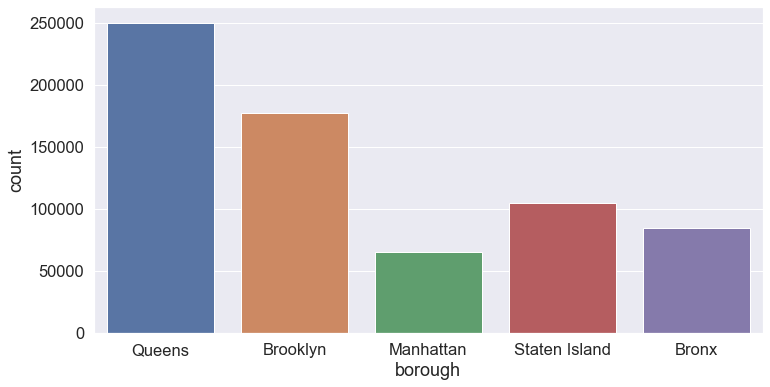

In [13]:
# Set the font scale to make the labels and ticks more readable
sb.set(font_scale = 1.5)
# Set the figure size
fig, axes = plt.subplots(figsize = (12, 6))
# Create the plot
plot = sb.countplot(trees['borough'])

### Which borough has the most "favorite" trees as voted on by registered users of the NYC Street Tree Map?
To answer this, we'll need to group by borough and count the number of votes:

In [14]:
# Group by borough and select the numberOfTimesFavorited column to run the sum and count
# aggregate functions on
trees.groupby('borough')['numberOfTimesFavorited'] \
     .agg(['sum','count']) \
     .rename(columns={'sum':'total_votes', 'count':'unique_trees_voted_on'}) \
     .sort_values(['total_votes'], ascending=[False])

,total_votes,unique_trees_voted_on
borough,,
Queens,341.0,331
Staten Island,73.0,69
Brooklyn,58.0,57
Bronx,21.0,21
Manhattan,16.0,15


As we can see, Queens has the most "favorite" trees with 341 votes and 331 unique trees voted on, not exactly surprising given the sheer advantage it has by way of tree count.

### How many dead trees there are?

To answer this we'll need to query the trees dataset to find trees that have a status not equal to alive and then get the shape:

In [15]:
# Query the trees dataframe and print the shape 
print(trees.query('status != "Alive"').shape[0])

31615


As we can see, there are 31,615 dead trees.

### How many are still standing? How many are stumps?
To answer this we'll need to query the trees dataset to find trees that have a status not equal to alive and then group by status and count the number of trees:

In [16]:
# Query the trees dataframe, group by status, and count the rows
trees.query('status != "Alive"') \
     .groupby('status') \
     .tree_id \
     .count() \
     .reset_index() \
     .rename(columns={'tree_id':'tree_count'}) \
     .sort_values(['tree_count'], ascending=[False])

,status,tree_count
1,Stump,17654
0,Dead,13961


As we can see, there are 13,961 standing dead trees and 17,654 stumps.

#### Let's visualize this by borough:

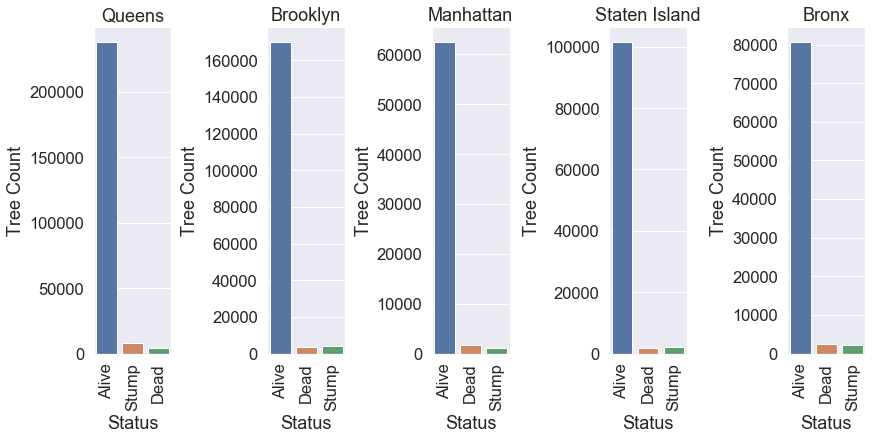

In [17]:
# Get the unique borough values from the tree dataframe
boroughs = trees.borough.unique()

# Set the font scale to make the labels and ticks more readable
sb.set(font_scale = 1.5)
# Set the number of columns for the subplots, the figure size, and constrained layout
fig, axes = plt.subplots(ncols = len(boroughs),
                         figsize = (12, 6),
                         constrained_layout = True)

# Loop through the boroughs to generate the countplot as subplots
for i, b in enumerate(boroughs):
    data = trees.query('borough == "{}"'.format(b))
    # Create the subplot
    plot = sb.countplot(data['status'], ax = axes[i%len(boroughs)])
    # Set the tick labels for the x axis
    plot.set_xticklabels(data['status'].unique(), rotation = 90)
    # Set the axis labels
    plot.set(xlabel = "Status",
             ylabel = "Tree Count", 
             title = "{}".format(b))

### What is the most common species?
To answer this, we'll need to group by species and count the number trees:

In [18]:
# Group by species name, count the rows, and sort descending by the count
trees.groupby('spc_common') \
     .tree_id \
     .count() \
     .reset_index() \
     .rename(columns={'tree_id':'tree_count'}) \
     .sort_values(['tree_count'], ascending=[False]) \
     .head(5)

,spc_common,tree_count
31,London planetree,87014
82,honeylocust,64264
12,Callery pear,58931
96,pin oak,53185
32,Norway maple,34189


As we can see, the most common species is the London planetree with 87,014 trees in NYC.

### What is the least common species?
To answer this, as with above we'll need to group by species and count the number trees:

In [19]:
# Group by species name, count the rows, and sort ascending by the count
trees.groupby('spc_common') \
     .tree_id \
     .count() \
     .reset_index() \
     .rename(columns={'tree_id':'tree_count'}) \
     .sort_values(['tree_count'], ascending=[True]) \
     .head(5)

,spc_common,tree_count
44,Virginia pine,10
39,Scots pine,25
36,Osage-orange,29
98,pitch pine,33
53,black pine,37


As we can see, the least common species is the Virginia pine with 10 trees in NYC.

### Which borough has the most 311 service requests for downed trees/limbs? Which borough has the least?
To answer this, we'll need to select only records where the request type contains Down and then group by borough and count the number of requests:

In [20]:
# Query the service_requests dataframe to only include requests where the request type contains Down
# Group by borough and then count the rows
service_requests.query('srtype.str.contains("Down")') \
                .groupby('boroughcode') \
                .srtype \
                .count() \
                .reset_index() \
                .rename(columns={'boroughcode':'borough' , 'srtype':'requests'}) \
                .sort_values(['requests'], ascending=[False])

,borough,requests
3,Queens,32548
1,Brooklyn,24396
4,Staten Island,8960
0,Bronx,7611
2,Manhattan,4794


As we can see, Queens has the most service requests with 32,548 and Manhattan has the least with 4,794.

### Which month has the most requests?
To answer this, we'll need to select only records where the request type contains Down and then group by month and count the number of requests:

In [21]:
# Query the service_requests dataframe to only include requests where the request type contains Down
# Select the month portion of createddate to group by and then count the rows
service_requests.query('srtype.str.contains("Down")') \
                        .groupby([service_requests.createddate.dt.strftime("%B").rename('month')]) \
                        .srtype \
                        .count() \
                        .reset_index() \
                        .rename(columns={'srtype':'requests'}) \
                        .sort_values(['requests'], ascending=[False])

,month,requests
5,July,11382
1,August,9240
10,October,8667
9,November,8440
6,June,7951
7,March,7601
8,May,6846
11,September,6154
0,April,4567
3,February,3414


July and August have the most service requests with 11,382 and 9,240 requests respectively.

### What is the average time for a service request to change from opened to closed in each borough?
To answer this, we'll need to calcuate the time difference between service request create dates and closed dates, and to filter out service requests without a closed date, then group by borough:

In [22]:
# Create a new column named time_diff that is calculated by subtracting the open date from the close date
service_requests['time_diff'] = service_requests['closeddate'] - service_requests['createddate']

# Query the service_requests dataframe to only include requests that have closed dates and where
# the request type contains Down. Group by borough, get the time_diff column and calcuate the mean
service_requests.query('closeddate == closeddate and srtype.str.contains("Down")') \
                            .groupby('boroughcode') \
                            .time_diff \
                            .mean(numeric_only=False) \
                            .reset_index() \
                            .rename(columns={'boroughcode':'borough', 'time_diff':'average_time'}) \
                            .sort_values(['average_time'], ascending=[False])

,borough,average_time
1,Brooklyn,50 days 17:39:44.768914
0,Bronx,45 days 22:50:07.993546
3,Queens,38 days 13:52:10.262435
4,Staten Island,19 days 09:36:58.213270
2,Manhattan,8 days 18:38:33.312222


As we can see, Brooklyn has the longest average time for open requests at 50 days, followed by Bronx with 45 days, Queens with 38 days, Staten Island with 19 days, and Manhattan with 8 days.

## Mapping the tree population density to a heatmap using GeoPandas and NYC Open Data Zip Code Boundaries shapefiles

Using GeoPandas, let's show the tree population on a heatmap. The shapefiles are available at https://data.cityofnewyork.us/Business/Zip-Code-Boundaries/i8iw-xf4u/data.

In [23]:
# Load the shapefile into a GeoPandas dataframe
zip_codes = gp.GeoDataFrame.from_file('data/nyc_zipcode_shapefiles/ZIP_CODE_040114.shp')
# Convert the zip code columns in the zip_codes and trees dataframes to int
zip_codes['zip_code'] = zip_codes['ZIPCODE'].astype(int)
trees['postcode'] = trees['postcode'].astype(int)

# Create a new dataframe from the trees dataframe, grouping by zip code and counting the trees
zip_tree_counts = trees.groupby('postcode') \
                        .tree_id \
                        .count() \
                        .reset_index() \
                        .rename(columns={'postcode':'zip_code', 'tree_id':'count'})

# Merge the zip_codes and zip_tree_counts dataframes
zip_tree_counts = gp.GeoDataFrame(zip_tree_counts.merge(
                                                        zip_codes,
                                                        how='left',
                                                        left_on='zip_code',
                                                        right_on='zip_code'
                                                        )
                                 )

# Drop null values to prevent issues with plotting the data
zip_tree_counts.dropna()
# Preview the data
zip_tree_counts.head(5)

,zip_code,count,ZIPCODE,BLDGZIP,PO_NAME,POPULATION,AREA,STATE,COUNTY,ST_FIPS,CTY_FIPS,URL,SHAPE_AREA,SHAPE_LEN,geometry
0,83,935,00083,0,Central Park,25.0,3.830099e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((998309.725 229616.681, 998282.853 22..."
1,10001,911,10001,0,New York,22413.0,1.779494e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981958.647 213464.453, 981980.328 21..."
2,10002,2265,10002,0,New York,81305.0,2.628013e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((991339.870 207576.784, 991330.490 20..."
3,10003,2025,10003,0,New York,55878.0,1.553838e+07,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((989830.469 207048.126, 989716.354 20..."
4,10004,118,10004,0,New York,2187.0,4.002521e+06,NY,New York,36,061,http://www.usps.com/,0.0,0.0,"POLYGON ((981197.409 196571.082, 981485.049 19..."


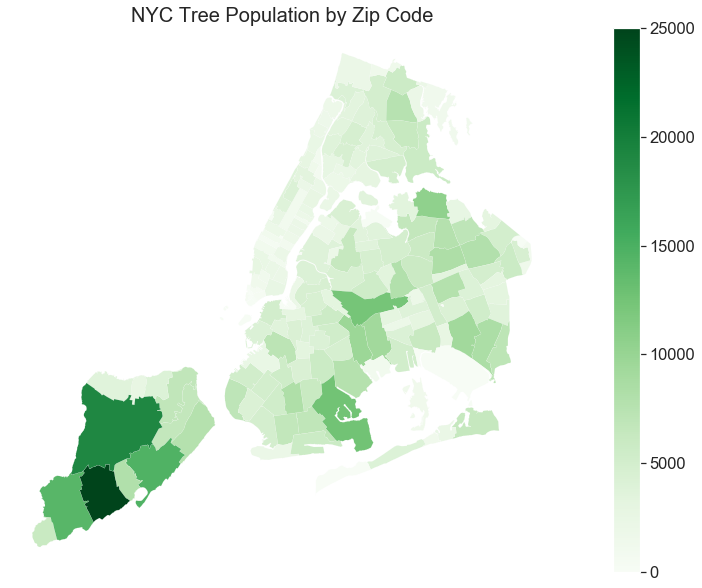

In [24]:
# Plot the data
fig, axes = plt.subplots(figsize = (20,10))
zip_tree_counts.plot(column = 'count',
                     cmap = 'Greens',
                     alpha = 1,
                     linewidth = 0.1,
                     ax = axes)

# Add a colorbar to the figure for showing the density scale
fig.colorbar(plt.cm.ScalarMappable(cmap = 'Greens',
                                   norm = plt.Normalize(vmin = 0,
                                                        vmax = 25000
                                                       )
                                  )
            )

# Set the title of the plot
plt.title('NYC Tree Population by Zip Code', size = 20)
# Hide the axis
plt.axis('off')

# Show the map
plt.show()

#### Although Queens has the highest total number of trees with ~250K, looking at the map, it appears that Staten Island has the highest density of trees.